In [ ]:
import tensorflow
import pandas
import json
import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive, files

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Kaggle'

kaggle.json


In [ ]:

with open('/content/drive/My Drive/Kaggle/kaggle.json') as f:
  auth = json.load(f)
  user = auth["username"]
  key = auth["key"]

In [ ]:
os.environ['KAGGLE_USERNAME'] = user
os.environ['KAGGLE_KEY'] = key

In [ ]:
!kaggle datasets download -d drscarlat/melanoma -p '/content/MyDrive/melanoma'

100% 5.26G/5.26G [01:48<00:00, 18.6MB/s]
100% 5.26G/5.26G [01:48<00:00, 51.9MB/s]


In [ ]:

%cd /content/MyDrive/melanoma

!unzip 'melanoma.zip'


Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

In [ ]:
!ls '/content/MyDrive/melanoma/DermMel'

test  train_sep  valid


In [ ]:
%cd /content/MyDrive/melanoma/DermMel

/content/MyDrive/melanoma/DermMel


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
minibatch_size = 64
pic_size = 96

data_train = ImageDataGenerator(rescale = 1.0/255.0)
data_valid = ImageDataGenerator(rescale = 1.0/255.0)
data_test = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = data_train.flow_from_directory('train_sep/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

validation_generator = data_valid.flow_from_directory('valid/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

test_generator = data_test.flow_from_directory('test/', 
                                                 color_mode = 'rgb',
                                                 batch_size = 1,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


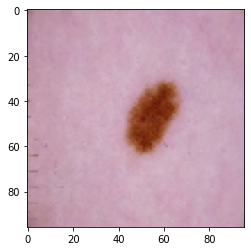

In [ ]:
plt.imshow(train_generator[0][0][7])
plt.show()

In [ ]:
input_shape_dim = train_generator[0][0].shape[1:]
input_shape_dim 

(96, 96, 3)

In [ ]:
out_shape = train_generator[0][1].shape[-1]
out_shape

2

In [ ]:
"""base_model = tensorflow.keras.applications.MobileNetV2(input_shape=input_shape_dim,
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling= None, 
                                                    classifier_activation="softmax"
                                                )"""

'base_model = tensorflow.keras.applications.MobileNetV2(input_shape=input_shape_dim,\n                                                    include_top=False,\n                                                    weights=\'imagenet\',\n                                                    pooling= None, \n                                                    classifier_activation="softmax"\n                                                )'

In [ ]:
base_model = tensorflow.keras.applications.MobileNetV2(input_shape=input_shape_dim,
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling= None, 
                                                    classifier_activation="softmax"
                                                )
global_average_layer = tensorflow.keras.layers.GlobalMaxPooling2D()
model = tensorflow.keras.Sequential()
model.add(base_model)
model.add(global_average_layer)
model.add(tensorflow.keras.layers.Dense(64, activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Dropout(0.3))

model.add(tensorflow.keras.layers.Dense(32, activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Dropout(0.25))
model.add(tensorflow.keras.layers.Dense(out_shape, activation ="softmax"))

In [ ]:
base_model.trainable = False

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                81984     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)               

In [ ]:
base_learning_rate = 1e-04
model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint("model.h5", 
                                                       monitor = "val_accuracy", 
                                                       verbose = 2, 
                                                       save_best_only = True,
                                                       mode = 'max'
                                                       )
callbacks_list = [checkpoint]

In [ ]:
EPOCHS = 15

history = model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, 
                    epochs = EPOCHS, 
                    validation_data = validation_generator, 
                    validation_steps= validation_generator.n //  validation_generator.batch_size,
                    callbacks= callbacks_list)

Epoch 1/15
166/166 [==============================] - 75s 433ms/step - loss: 0.6636 - accuracy: 0.6880 - val_loss: 0.2058 - val_accuracy: 0.9222

Epoch 00001: val_accuracy improved from -inf to 0.92216, saving model to model.h5
Epoch 2/15
166/166 [==============================] - 71s 426ms/step - loss: 0.2755 - accuracy: 0.8928 - val_loss: 0.1781 - val_accuracy: 0.9335

Epoch 00002: val_accuracy improved from 0.92216 to 0.93352, saving model to model.h5
Epoch 3/15
166/166 [==============================] - 71s 428ms/step - loss: 0.2192 - accuracy: 0.9195 - val_loss: 0.1694 - val_accuracy: 0.9369

Epoch 00003: val_accuracy improved from 0.93352 to 0.93693, saving model to model.h5
Epoch 4/15
166/166 [==============================] - 71s 426ms/step - loss: 0.2064 - accuracy: 0.9223 - val_loss: 0.1630 - val_accuracy: 0.9384

Epoch 00004: val_accuracy improved from 0.93693 to 0.93835, saving model to model.h5
Epoch 5/15
166/166 [==============================] - 70s 424ms/step - loss: 0.

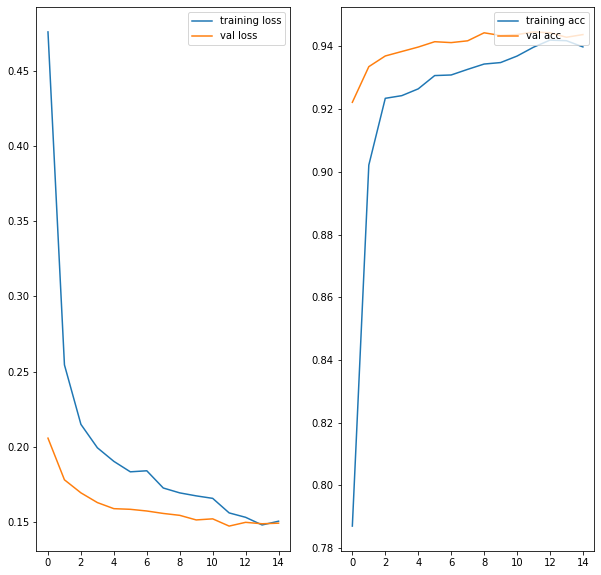

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='upper right')

plt.show()

In [ ]:
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_weights("model.h5")

In [ ]:
model.evaluate(validation_generator, steps = validation_generator.n //  validation_generator.batch_size )

55/55 [==============================] - 19s 339ms/step - loss: 0.1477 - accuracy: 0.9440


[0.14771768450737, 0.9440340995788574]

In [ ]:
test_generator.reset()
preds = model.predict(test_generator, steps = test_generator.n//test_generator.batch_size, verbose = 1)

3561/3561 [==============================] - 35s 10ms/step


In [ ]:
model.evaluate(test_generator, steps = test_generator.n//test_generator.batch_size )

3561/3561 [==============================] - 37s 10ms/step - loss: 0.1709 - accuracy: 0.9343


[0.17089709639549255, 0.9342881441116333]